# Assignment 6

Name 1: Sharmila Upadhyaya  <br/>
Student id 1: 7008858  <br/>
Email 1: shup00001@stud.uni-saarland.de  <br/>


Name 2: Isidora Jeknic <br/>
Student id 2: 7008924<br/>
Email 2: isje00001@stud.uni-saarland.de  <br/> 

**Instructions:** Read each question carefully. <br/>
Make sure you appropriately comment your code wherever required. Your final submission should contain the completed Notebook and the Python file for exercise 3. There is no need to submit the data files. <br/>
Upload the zipped folder in Teams. Make sure to click on "Turn-in" after your upload your submission, otherwise the assignment will not be considered as submitted. Only one from the group should make the submisssion.

---

## Exercise 1: MLE & MAP  (3 points)

Here is a nice [article](http://pages.cs.wisc.edu/~jerryzhu/cs838/LM.pdf) that explains the difference between MLE and MAP based estimation for language models. 

**1.1 (1 point)**

* Is a MAP estimator always better than MLE? Why is MAP preferred over MLE (explain in context of language modelling)? (0.5 points)

* Some smoothing methods use a MAP estimation of the model parameters. One of these is floor discounting, as described on Slide 44 in Chapter 5. <br/>
Write the formula for deriving the MAP estimate and the resultant formula for floor discounting. What underlying distribution does the language model assume? What is assumed as the prior? (0.5 pts)

**1.2 (2 points)**

Consider the sentences

`s1 = They don't know that we know they know!`

`s2 = Don't we know that?`

* Assume punctuation removal and lowercasing as basic preprocessing steps. Formulate a bigram model (use a circular corpus) on `s1`, note down the conditional probabilities, and use them to determine the probability of `s2`. (0.5 pt)
* Now use floor discounting and form similar bigram models with $\epsilon=1$ and $\epsilon=0.5$, note down the respective bigram probabilities, and use them to determine the probability of `s2`. (1 pt) 
* What do you observe? How does the value of $\epsilon$ influence the MAP prior in both cases? (0.5 pts)

## Answer

# 1.1 #
<br>
- Not necessarily, it depends on the task. <br> MLE has many issues, including data sparseness. The counts of unseen words will be 0, making the probability of the entire sentence/sequence that it is found in 0, which tremendously skewes the probability distribution. With MAP, this is avoided by assigning some probability mass from the higher counts to the zero counts.
- MAP formula:  
$\underset{\theta}{\operatorname{argmax}} ∑_ilog{P(w_i|θ)} + \log{P(θ)}$
<!-- $\theta_w^{MAP} = \frac{C(w) + \alpha - 1}{|V| + \sum_i^V(\alpha - 1)}$ -->

- Add-epsilon formula:  
$P(w|h) = \frac{C(w, h) + \epsilon}{C(h) + \epsilon V}$  
- The model assumes an underlying multinomial distribution with a Dirichlet prior.


# 1.2 #

In [217]:
s1 = "They don't know that we know they know!"
s2 = "Don't we know that?"
s1_prep = preprocess(s1)
s2_prep = preprocess(s2)
bigrams = make_circ_bigrams(s1_prep)
vocab = set(s1_prep + s2_prep) 

In [218]:
from collections import Counter

def preprocess(s):
    new_s = []
    for char in s:
        if char.isspace() or char.isalnum():
            new_s.append(char.lower())   
        else:
            pass
        
    new_s_str = "".join(new_s)
    
    return new_s_str.split()

def make_circ_bigrams(tokens):
    bigs = []
    for i in range(len(tokens)-1):
        bigs.append((tokens[i], tokens[i+1]))
    bigs += [(tokens[-1], tokens[0])]
    return bigs


def calculate_cond_probs(s, norm_bigs=Counter(bigrams), norm_unis=Counter(s1_prep)):
    
    s_cond_probs = {}
    # P(B|A) = P(A,B) / P(A)
    for el in s:
        # el = (A,B)
        try:
            joint_p_a_b = norm_bigs[el]
            prob_a = norm_unis[el[0]]
        except:
            joint_p_a_b = 0
            prob_a = 0
        try:
            s_cond_probs[(el[1], el[0])] = joint_p_a_b / prob_a
        except ZeroDivisionError:
            s_cond_probs[(el[1], el[0])] = 0
            
    return s_cond_probs

In [219]:
# norm_bigs = {k:v/len(bigrams) for k,v in Counter(bigrams).items()}
# norm_unis = {k:v/len(s1_prep) for k,v in Counter(s1_prep).items()}
cond_probs = calculate_cond_probs(bigrams)

In [220]:
cond_probs

{('dont', 'they'): 0.5,
 ('know', 'dont'): 1.0,
 ('that', 'know'): 0.3333333333333333,
 ('we', 'that'): 1.0,
 ('know', 'we'): 1.0,
 ('they', 'know'): 0.6666666666666666,
 ('know', 'they'): 0.5}

In [221]:

s2_prep = make_circ_bigrams(preprocess(s2))

In [222]:
s2_cond_probs = calculate_cond_probs(s2_prep)

In [223]:
s2_cond_probs

{('we', 'dont'): 0.0,
 ('know', 'we'): 1.0,
 ('that', 'know'): 0.3333333333333333,
 ('dont', 'that'): 0.0}

So, pconditional probability of s2 using s1 would be 0

In [224]:
# add-epsilon smoothing for sentence 2

# P(B|A) =
# (C(A,B) + e) / (C(A) + eV)


e = 0.5
add_eps = {}
for el in s2_prep:
    top = Counter(bigrams)[el] + e
    bottom = Counter(s1_prep)[el[0]] + e*len(vocab)
    add_eps[(el[1], el[0])] = top/bottom

In [225]:

print("Conditional probability of each pair: ")
print(add_eps)


Conditional probability of each pair: 
{('we', 'dont'): 0.14285714285714285, ('know', 'we'): 0.42857142857142855, ('that', 'know'): 0.2727272727272727, ('dont', 'that'): 0.14285714285714285}


In [226]:
print("Conditional probability of sentence: ")
result = 1
for k,v in add_eps.items():
    result *= v
    
print(result)

Conditional probability of sentence: 
0.0023853697323085073


In [227]:
# estimating s2 probabilities with add-epsilon smoothing
e = 1
add_eps_2 = {}
for el in s2_prep:
    top = Counter(bigrams)[el] + e
    bottom = Counter(s1_prep)[el[0]] + e*len(vocab)
    add_eps_2[(el[1], el[0])] = top/bottom

In [228]:

print("Conditional probability of each pair: ")
print(add_eps_2)


Conditional probability of each pair: 
{('we', 'dont'): 0.16666666666666666, ('know', 'we'): 0.3333333333333333, ('that', 'know'): 0.25, ('dont', 'that'): 0.16666666666666666}


In [229]:
print("Conditional probability of sentence: ")
result = 1
for k,v in add_eps_2.items():
    result *= v
    
print(result)

Conditional probability of sentence: 
0.0023148148148148147


- Greater $\epsilon$ value makes for a more evenly distributed probability mass, i.e. creates a smoother distribution.

## Exercise 2: Good-Turing (3 points)

#### 2.1: Estimate of unknown words (0.5 points)

Imagine that you're given a split into (1) training data and (2) test data. They come from the same distribution but you're forbidden to make any other splits.

- What is the MLE estimate of frequency of unseen words on (2)?
- What other, better, strategy could be employed to estimate frequency of unseen words from (1) on (2)?

#### 2.2: Data split (0.5 points)

- Usually when preparing a new model, we split the dataset to (1) training data, (2) held-out data and (3) test data. Comment briefly on what each part of the dataset is used for and especially on the distinction between (1) and (2).

#### 2.3: Good-Turing Formula (1 point)

- What is the formula for updated counts for words of frequency $k \ne 0$?
- What is the Good-Turing formula for estimating unseen words, $k=0$?
- Given the updated counts $c^*_k$, how does Good-Turing estimate relate to language model smoothing? How do you define the smoothed distribution?
- Is there any systematic relationship between the original counts and the new counts? e.g. for large enough $k$, $c^*_k \ge k$. 
- Compute and compare the absolute frequencies and Good-Turing estimates for the words `three` and `syringes` in the following text.

```
thirty - three thousand three hundred and thirty silver syringes which cost three hundred and thirty - two crowns . .
```

#### 2.4: Frequent buckets (1 point)

- In your own words, what is the issue with Good-Turing when estimating the new counts for the very frequent words?
- See page 5, paragraph 3 of [Good‐Turing Smoothing Without Tears](http://deanfoster.net/teaching/data_mining/good_turing.pdf) by Gale and Sampson (1995). What solution do they propose?

## **Answer**

2.1  
- MLE would estimate the frequency of unseen words to be 0.
- We could use the count of words that have occurred once (=1) in the train set to generalize the frequency of unseen words in the test set by taking the total probability mass taken up by these one-off words and distributing it accross the unseen words from the test corpus.

2.2  
Training data is used for initial estimation of probabilities; held-out data is taken from the training data and is used for validation of different models; test data is used to test model performance is by utilizing the parameters established with the train and held-out sets. 


2.3  
- $c^* = \frac{(c+1)N_{c+1}}{N_c}$
- $c^* = \frac{N_1}{N}$ 
- Good-Turing counts are what would be considered smoothed counts; however, proper smoothing has to be employed for large $k$ values (see 2.4).
- If $k$ is large enough, $c_k^* = c_k$, which is a fundamental issue with this technique.



In [230]:
from collections import Counter
text = 'thirty - three thousand three hundred and thirty silver syringes which cost three hundred and thirty - two crowns . .'
split_text = text.split()
count = sorted(Counter(split_text).items(), key=lambda item: item[1], reverse=True)
abs_freq = [(w, v/len(split_text)) for w,v in count]
for i in range(len(count)):
    print(count[i][0], '\t\t', count[i][1], '\t\t', abs_freq[i][1])

thirty 		 3 		 0.14285714285714285
three 		 3 		 0.14285714285714285
- 		 2 		 0.09523809523809523
hundred 		 2 		 0.09523809523809523
and 		 2 		 0.09523809523809523
. 		 2 		 0.09523809523809523
thousand 		 1 		 0.047619047619047616
silver 		 1 		 0.047619047619047616
syringes 		 1 		 0.047619047619047616
which 		 1 		 0.047619047619047616
cost 		 1 		 0.047619047619047616
two 		 1 		 0.047619047619047616
crowns 		 1 		 0.047619047619047616


- syringes  
$N = 21$  
$c_{syringes} = 1$  
$N_1 = 7$  
$N_2 = 4$  
$c^*_{syringes} = \frac{(c_{syringes}+1) N_{c_{syringes}+1}}{N_{c_{syringes}}} = \frac{(1+1) 4}{7} = \frac{8}{7}$   
 
<!-- $P^*GT_{syringes} = \frac{\frac{8}{7}}{21} = 0.054$ -->

- 'three'  
$N = 21$  
$N_1 = 7$  
$c_{three} = 3$  
$N_3 = 2$  
$N_4 = 0$  
Since k is large,
$c^*_{three} = \frac{(3+1) N_4}{N_3}$
But, because of largest value of k, it is given that $c_k^* = c_k$
$= 3$


2.4  
- The issues with reestimating the counts with Good-Turing smoothing is that, for the highly frequent words, there won't be a $N_{(c+1)}$ and the updated counts would be 0.
- They propose to "estimate the expected $N_r$ by the density of $N_r$ for large $r$" ($r = k$) by averaging the non-zero $N_k$ that surround the zero $N_k$, order by $k$ and take $q$, $k$, and $t$ which are subsequent values of indices; they propose applying the formula $N_k^* = \frac{N_k}{0.5(t−q)}$



## Exercise 3: Cross-Validation (4 points)

<!-- ### 3.0 Bible studies -->

Imagine you are a linguist in the remote future who just rediscovered a book called "Bible". To your disappointment the book is obviously incomplete; all the pages between Genesis and the Apocalypse are torn out, maybe by some late Christian cult. Since you don't know the language of the book you want to build a first language model that you can use if you find any of the lost parts. You digitize the book with your state-of-the art portable digitizer, and then load it into one of your Python 10.0 notebooks.

**3.1 Baseline (0.5 points)**

* The two corpora are in the text files `genesis.txt` and `apocalypsis.txt`. Load them into the notebook, preprocess them by removing all non-alphabetical characters, and then concatenate them into a single corpus. Split the corpus into a train and a test set, with the test set comprising the _last_ 20% of the corpus. You may use your code from previous exercises for this. (0.25 points)


In [231]:
# Load data
from importlib import reload
import exercise_3
from pathlib import Path
exercise_3 = reload(exercise_3)

genesis_text = Path("data/genesis.txt").open('r').read()
apocalypsis_text = Path("data/apocalypsis.txt").open('r').read()

# TODO: preprocess
genesis_preprocessed = exercise_3.preprocess(genesis_text)
apocalypsis_preprocessed = exercise_3.preprocess(apocalypsis_text)

# TODO: concatenate
corpus = genesis_preprocessed + apocalypsis_preprocessed

# # TODO: train, test split
train, test = exercise_3.train_test_split_data(corpus, test_size=0.3)

* Using your language model class from the previous assignment, estimate a trigram language model on the train set and report perplexity on the test. Use $\alpha=1$. Does this represent an unbiased estimate of the model's capacity? (0.25 points)

In [232]:
import lm

lm = reload(lm)

# TODO: trigram LM
LM = lm.LanguageModel(train, test, N=3, alpha=1)
pp = LM.perplexity()
print("Average Perplexity for k fold validation will be: " + str(pp[2]))

Average Perplexity for k fold validation will be: 3638.518526083138


**3.2 Average Perplexity (2 points)**

* Since you want to get an unbiased estimate of your model's capacity, you decide to apply k-fold cross-validation on your corpus. To do this, implement the function `k_validation_folds` in `exercise_2.py`. Use it to split your corpus into $k=5$ cross-validation folds, and make sure that the folds are of the same size. (1 point)

* Now, estimate a trigram language model on each of the CV folds. You may again use your class from the previous assignment, and average over all perplexity scores. Does the average score differ from the one obtained in 3.2, and why? (1 point)

In [233]:
# 10-fold cross-validation
cv_folds = exercise_3.k_validation_folds(corpus, k_folds=5)

assert all([len(cv_fold) for cv_fold in cv_folds])
# TODO: estimate 10 trigram LMs!
pps = []
for i in range(0, len(cv_folds)):
    test = cv_folds[i]
    train = cv_folds[i-1:i] + cv_folds[i+1:] if i != 0 else cv_folds[i+1:]
    train = [item for sublist in train for item in sublist]
    LM = lm.LanguageModel(train, test, N=3, alpha=1)
    pp = LM.perplexity()
    pps.append(pp[2])

In [234]:
print("Average Perplexity for k fold validation will be: " + str(sum(pps)/len(pps)))

Average Perplexity for k fold validation will be: 2868.1189805624817


# 3.2 Answer #

The average perplexity is lower than the one done in 3.1 due to cross fold validation. As doing the train test split, the portion of train data might not be representative and the test perplexity got higher. However, in cross kfold, using each 4th portion or 80 % of train data each time so that we tried to remove the biasness caused by the split of data. Hence, result is much more better.

**3.3 Hyperparameter Tuning (1.5 points)**

* As you don't know anything about the language the book is written in, you have to find the best hyperparemter $\alpha$ for your model by a brute-force search (recall how you did this in the last assignment). Since you know from 3.2 that your data is not balanced, you decide to use only the averaged perplexity score (derived from $k=10$ CV folds) for this. Do so by completing the loop in the code cell below. Then, plot the obtained perplexity scores vs. $\alpha$. You do so by reusing the respective function from Assignment 5. (1 point)

(**Hint:** This could take a while.)

Plot for trigram model:


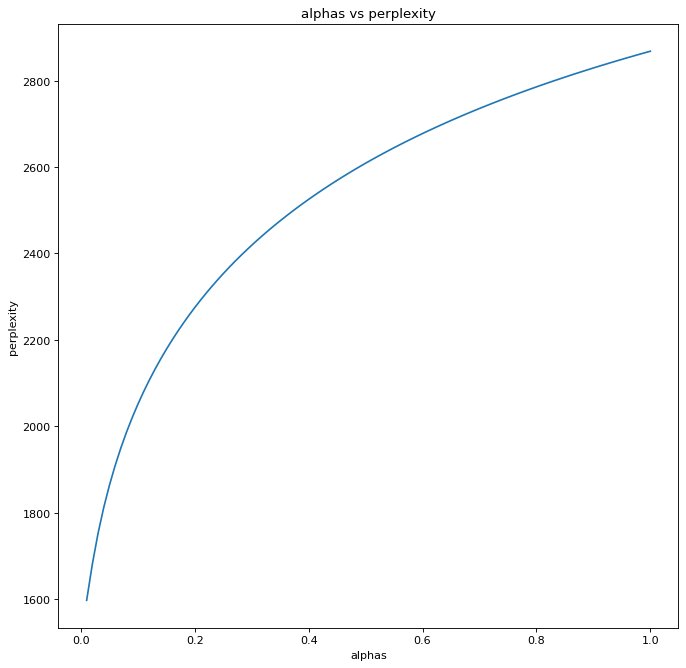

In [235]:
# hyperparamter tuning, CV
alphas = [x*0.01 for x in range(1,101)]
pps = []
for alpha in alphas:
    pps_each = []
    for i in range(len(cv_folds)):
        test = cv_folds[i]
        train = cv_folds[i-1:i] + cv_folds[i+1:] if i != 0 else cv_folds[i+1:]
        train = [item for sublist in train for item in sublist]
        LM = lm.LanguageModel(train, test, N=3, alpha=alpha)
        pp = LM.perplexity()
        pps_each.append(pp[2])
    pps.append(sum(pps_each)/len(pps_each))
    
print("Plot for trigram model:")
exercise_3.plot_pp_vs_alpha(pps, alphas = alphas)

* Repeat the tuning process for unigram and bigram language models. Does your estimate of $\alpha$ differ? Why? (0.5 points)

Plot for unigram model:


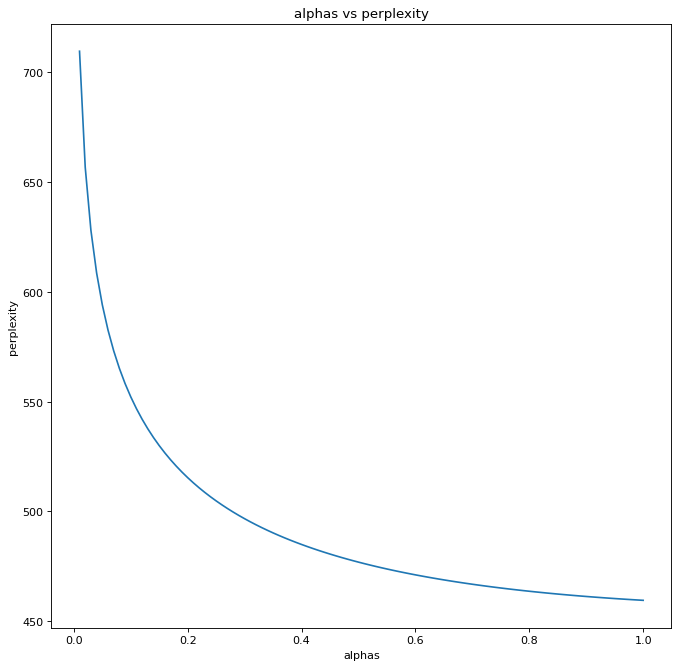

Plot for bigram model:


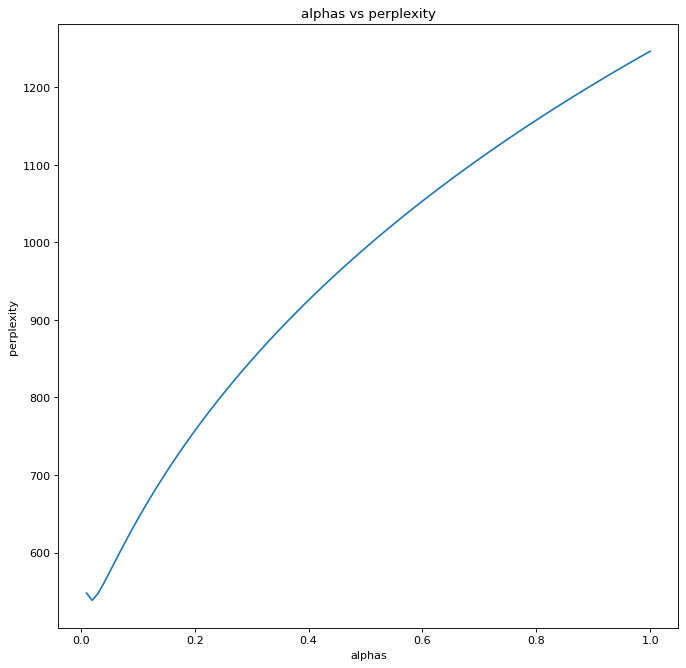

In [236]:
# hyperparamter tuning, bigram + trigram
# hyperparamter tuning, CV
alphas = [x*0.01 for x in range(1,101)]
pps_unigram = []
pps_bigram = []
for alpha in alphas:
    pps_each_unigram = []
    pps_each_bigram = []
    for i in range(len(cv_folds)):
        test = cv_folds[i]
        train = cv_folds[i-1:i] + cv_folds[i+1:] if i != 0 else cv_folds[i+1:]
        train = [item for sublist in train for item in sublist]
        LM = lm.LanguageModel(train, test, N=3, alpha=alpha)
        pp = LM.perplexity()
        pps_each_unigram.append(pp[0])
        pps_each_bigram.append(pp[1])
    pps_unigram.append(sum(pps_each_unigram)/len(pps_each))
    pps_bigram.append(sum(pps_each_bigram)/len(pps_each))
print("Plot for unigram model:")
exercise_3.plot_pp_vs_alpha(pps_unigram, alphas = alphas)
print("Plot for bigram model:")
exercise_3.plot_pp_vs_alpha(pps_bigram, alphas = alphas)

# 3.3 Answer #

In above observation, perplexity increases with alpha for bigram model which totally depends upon the corpus and the amount of unseen and seen bigrams. Hence, for bigram model we will be taking lower alpha value to get optimum result. However, for unigram perplexity decreases with increase in alpha. Hence, we will take higher alpha value.